# Imports

In [153]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import re
import nltk
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from textblob import TextBlob
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
#Models
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB

In [154]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\bmattis\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\bmattis\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\bmattis\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [155]:
colnames=['label','id','date','query','user','text']
df = pd.read_csv('data/tweets.csv', header=None, names=colnames, encoding = "ISO-8859-1")
df.head(2)

,label,id,date,query,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...


In [156]:
df.shape

(1600000, 6)

# PreProcess

In [157]:
df=df.sample(100000)

In [158]:
df.duplicated().any()

False

array([[<AxesSubplot:title={'center':'label'}>]], dtype=object)

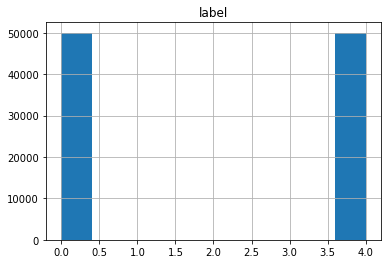

In [159]:
df.hist('label')

In [160]:
df.date = pd.to_datetime(df.date, utc=True, infer_datetime_format=True)

#format='%a %b %d %H:%M:%S %Z %Y'

C:\Users\bmattis\.conda\envs\dataScience\lib\site-packages\dateutil\parser\_parser.py:1213: UnknownTimezoneWarning: tzname PDT identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  warnings.warn("tzname {tzname} identified but not understood.  "


In [161]:
df.dtypes

label                  int64
id                     int64
date     datetime64[ns, UTC]
query                 object
user                  object
text                  object
dtype: object

In [162]:
df['text'] = df['text'].astype(str)

In [163]:
df.head()

,label,id,date,query,user,text
618508,0,2227543800,2009-06-18 13:19:48+00:00,NO_QUERY,SarahMorrison,@vodkatrina hahahahaah OMG I swear to gawd I d...
834361,4,1557940849,2009-04-19 06:39:41+00:00,NO_QUERY,pascy,@nickless if you don't forget to answer my que...
216560,0,1975734314,2009-05-30 15:47:14+00:00,NO_QUERY,KatieMarie09,is HUNGRY ahh i wish i could chew
776764,0,2322238209,2009-06-24 22:16:28+00:00,NO_QUERY,bryanmero,Finally home! Gotta go to work tomorrow
1365697,4,2050005119,2009-06-05 17:53:42+00:00,NO_QUERY,WerewolfJared,@Anime81 Just give me some time


In [164]:
df.tail()

,label,id,date,query,user,text
1310726,4,2013358526,2009-06-02 22:29:16+00:00,NO_QUERY,immaterialdepth,"@thisgirln no prob, yo. I miss you already. t..."
183373,0,1967407717,2009-05-29 19:31:27+00:00,NO_QUERY,kkavjonas526,@iamthecommodore awww comeon ive never talked ...
453204,0,2070246549,2009-06-07 17:21:14+00:00,NO_QUERY,bma,"SWEng declared. #greens beat labour, but no se..."
1130334,4,1975678267,2009-05-30 15:40:04+00:00,NO_QUERY,chrisreike,@Heatherlyb Sounds hot.
157072,0,1956286093,2009-05-28 21:33:27+00:00,NO_QUERY,idaremyidea,@efnik Hey! are you Ian from efnik? or rya nik...


# EDA

In [165]:
# plotting sentiment posts by hour

In [166]:
hoursGroup = df.groupby(df.date.dt.hour)['label'].value_counts().unstack(level=1).reset_index()
hoursGroup.head()

label,date,0,4
0,0,2264,2755
1,1,2007,2782
2,2,1859,2710
3,3,1992,2640
4,4,2192,2569


In [167]:
hoursGroup.rename(columns={'date':'hour',0:'sent_0',4:'sent_4'}, inplace=True)

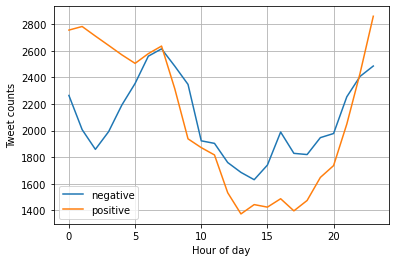

In [168]:
plt.plot(hoursGroup.hour, hoursGroup.sent_0, label='negative')
plt.plot(hoursGroup.hour, hoursGroup.sent_4, label='positive')
plt.xlabel('Hour of day')
plt.ylabel('Tweet counts')
plt.legend()
plt.grid()
plt.show()

In [169]:
#list top 5 users for each sentiment level

In [170]:
top5pos = df[df.label==4].groupby('user').count().sort_values(by=['label'],ascending=False)
top5pos.head()

,label,id,date,query,text
user,,,,,
DarkPiano,18,18,18,18,18
what_bugs_u,17,17,17,17,17
thisgoeshere,16,16,16,16,16
VioletsCRUK,16,16,16,16,16
tsarnick,14,14,14,14,14


In [171]:
top5neg = df[df.label==0].groupby('user').count().sort_values(by=['label'],ascending=False)
top5neg.head()

,label,id,date,query,text
user,,,,,
lost_dog,46,46,46,46,46
tweetpet,20,20,20,20,20
SallytheShizzle,17,17,17,17,17
webwoke,15,15,15,15,15
SarahMorrison,12,12,12,12,12


In [172]:
# Average length of the tweets for each sentiment level

In [173]:
dfLength = df
dfLength.text = dfLength.text.astype(str)
dfLength['tlen'] = dfLength.text.str.len()
dfLength.head()

,label,id,date,query,user,text,tlen
618508,0,2227543800,2009-06-18 13:19:48+00:00,NO_QUERY,SarahMorrison,@vodkatrina hahahahaah OMG I swear to gawd I d...,101
834361,4,1557940849,2009-04-19 06:39:41+00:00,NO_QUERY,pascy,@nickless if you don't forget to answer my que...,68
216560,0,1975734314,2009-05-30 15:47:14+00:00,NO_QUERY,KatieMarie09,is HUNGRY ahh i wish i could chew,35
776764,0,2322238209,2009-06-24 22:16:28+00:00,NO_QUERY,bryanmero,Finally home! Gotta go to work tomorrow,40
1365697,4,2050005119,2009-06-05 17:53:42+00:00,NO_QUERY,WerewolfJared,@Anime81 Just give me some time,32


In [174]:
avgTlength = dfLength.groupby('label')['tlen'].mean()

In [175]:
avgTlength[:2]

label
0    74.388578
4    73.932325
Name: tlen, dtype: float64

<AxesSubplot:xlabel='Sentiment', ylabel='Average Tweet Length'>

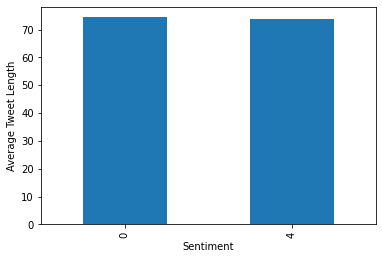

In [176]:
avgTlength.plot(kind='bar', ylabel='Average Tweet Length', 
                xlabel='Sentiment')

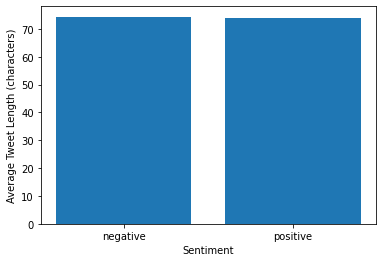

In [177]:
plt.bar(['negative','positive'],avgTlength)
plt.xlabel('Sentiment')
plt.ylabel('Average Tweet Length (characters)')
plt.show()

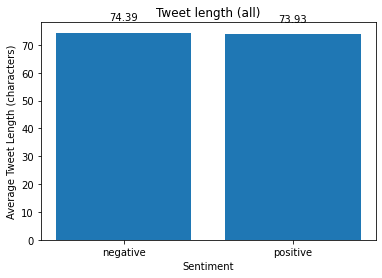

In [178]:
fig, ax = plt.subplots()
rects1=ax.bar(['negative','positive'],avgTlength)
ax.set_xlabel('Sentiment')
ax.set_ylabel('Average Tweet Length (characters)')
ax.set_title('Tweet length (all)')
def autolabel(rects):   
    for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2., 1.05*height,
                '%.2f' % float(height),
                ha='center', va='bottom')

autolabel(rects1)
plt.show()

In [179]:
# Average length of the top-5 tweets for each level of sentiment

In [180]:
top5_neg = dfLength[dfLength.label==0].groupby('text').tlen.agg(['count','mean']).sort_values(by=['count'],ascending=False).head().reset_index()
top5_pos = dfLength[dfLength.label==4].groupby('text').tlen.agg(['count','mean']).sort_values(by=['count'],ascending=False).head().reset_index()
top5_pos

,text,count,mean
0,good morning,9,13
1,Good morning,9,13
2,goodnight,7,10
3,Goodnight,7,10
4,"Not to worry, noone got that one. Next questio...",6,94


In [181]:
top5_neg

,text,count,mean
0,isPlayer Has Died! Sorry,11,25
1,headache,7,9
2,at work,7,8
3,"Jogging, isnt REALLY that cool, especially if ...",7,65
4,Headache,7,9


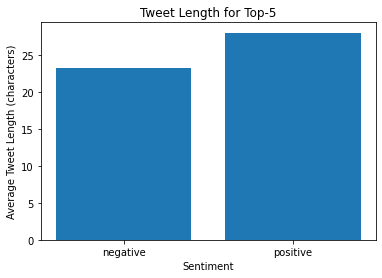

In [182]:
plt.bar(['negative','positive'],[top5_neg['mean'].mean(),top5_pos['mean'].mean()])
plt.xlabel('Sentiment')
plt.ylabel('Average Tweet Length (characters)')
plt.title('Tweet Length for Top-5')
plt.show()

In [183]:
dfLength[dfLength.label==0].groupby('text').count().sort_values(by=['tlen'],ascending=False).head()

,label,id,date,query,user,tlen
text,,,,,,
isPlayer Has Died! Sorry,11,11,11,11,11,11
headache,7,7,7,7,7,7
at work,7,7,7,7,7,7
"Jogging, isnt REALLY that cool, especially if you've got a fever",7,7,7,7,7,7
Headache,7,7,7,7,7,7


# Text Cleaning

## Punctuation

In [184]:
def form_sentence(tweet):
    tweet_blob = TextBlob(tweet)
    return ' '.join(tweet_blob.words)

Example of implementation

In [185]:
df['text'].iloc[10]

'@Thecathy  maybe a good thing at this hour !'

In [186]:
print(form_sentence(df['text'].iloc[10]))

Thecathy maybe a good thing at this hour


## Stopwords

In [187]:
def no_user_alpha(tweet):
    tweet_list = [ele for ele in tweet.split() if ele != 'user']
    clean_tokens = [t for t in tweet_list if re.match(r'[^\W\d]*$', t)]
    clean_s = ' '.join(clean_tokens)
    clean_mess = [word for word in clean_s.split() if word.lower() not in stopwords.words('english')]
    return clean_mess

In [188]:
print(no_user_alpha(form_sentence(df['text'].iloc[10])))

['Thecathy', 'maybe', 'good', 'thing', 'hour']


## Uniformity

In [189]:
# the v is normalizing the verbs, but ignoring others.  Full lemmatize function here:
# https://www.geeksforgeeks.org/python-lemmatization-approaches-with-examples/
def normalization(tweet_list):
    lem = WordNetLemmatizer()
    normalized_tweet = []
    for word in tweet_list:
        normalized_text = lem.lemmatize(word,'v')
        normalized_tweet.append(normalized_text)
    return normalized_tweet

In [190]:
normalization('Oh that is fantastic'.split())

['Oh', 'that', 'be', 'fantastic']

# Modelling

## One-hot and TF-IDF

In [191]:
pipelineSVC = Pipeline([
    ('bow',CountVectorizer(analyzer='word')), # quantify text contents by word
    ('tfidf', TfidfTransformer()), # Weighted TF-IDF scores
    ('classifier', SVC(verbose=True)), # train on TF-IDF vectors w/ SVC
], verbose=True)

In [192]:
X_train, X_test, y_train, y_test = train_test_split(df['text'], df['label'], test_size=0.2)

In [193]:
pipelineSVC.fit(X_train,y_train)

[Pipeline] ............... (step 1 of 3) Processing bow, total=   2.5s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.4s
[LibSVM][Pipeline] ........ (step 3 of 3) Processing classifier, total=48.6min


Pipeline(steps=[('bow', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('classifier', SVC(verbose=True))],
         verbose=True)

In [194]:
predSVC = pipelineSVC.predict(X_test)

In [195]:
# "accuracy is a great measure but only when you have symmetric datasets where values of false 
# positive and false negatives are almost same"
print(classification_report(predSVC,y_test))

              precision    recall  f1-score   support

           0       0.79      0.79      0.79     10007
           4       0.79      0.79      0.79      9993

    accuracy                           0.79     20000
   macro avg       0.79      0.79      0.79     20000
weighted avg       0.79      0.79      0.79     20000



0 and 4 have similar counts and similar recall and precision.  Not surprising that F1-score and accuracy are closely matched

In [196]:
pipelineDT = Pipeline([
    ('bow',CountVectorizer(analyzer='word')), # quantify text contents by word
    ('tfidf', TfidfTransformer()), # Weighted TF-IDF scores
    ('classifier', DecisionTreeClassifier()), # train on TF-IDF vectors w/ DT
], verbose=True)

In [197]:
pipelineDT.fit(X_train,y_train)

[Pipeline] ............... (step 1 of 3) Processing bow, total=   2.4s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.1s
[Pipeline] ........ (step 3 of 3) Processing classifier, total= 1.3min


Pipeline(steps=[('bow', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('classifier', DecisionTreeClassifier())],
         verbose=True)

In [198]:
predDT = pipelineDT.predict(X_test)

In [199]:
print(classification_report(predDT,y_test))

              precision    recall  f1-score   support

           0       0.68      0.68      0.68     10049
           4       0.68      0.68      0.68      9951

    accuracy                           0.68     20000
   macro avg       0.68      0.68      0.68     20000
weighted avg       0.68      0.68      0.68     20000



In [200]:
pipelineNB = Pipeline([
    ('bow',CountVectorizer(analyzer='word')), # quantify text contents by word
    ('tfidf', TfidfTransformer()), # Weighted TF-IDF scores
    ('classifier', MultinomialNB()), # train on TF-IDF vectors w/ DT
], verbose=True)

In [201]:
pipelineNB.fit(X_train,y_train)

[Pipeline] ............... (step 1 of 3) Processing bow, total=   2.1s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.1s
[Pipeline] ........ (step 3 of 3) Processing classifier, total=   0.0s


Pipeline(steps=[('bow', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('classifier', MultinomialNB())],
         verbose=True)

In [202]:
predNB = pipelineNB.predict(X_test)

In [203]:
print(classification_report(predNB,y_test))

              precision    recall  f1-score   support

           0       0.83      0.73      0.78     11372
           4       0.69      0.80      0.74      8628

    accuracy                           0.76     20000
   macro avg       0.76      0.76      0.76     20000
weighted avg       0.77      0.76      0.76     20000



In [204]:
confusion_matrix(y_test, predSVC)

array([[7922, 2113],
       [2085, 7880]], dtype=int64)

In [205]:
print(confusion_matrix(y_test, predDT))

[[6854 3181]
 [3195 6770]]


In [206]:
print(confusion_matrix(y_test, predNB))

[[8299 1736]
 [3073 6892]]


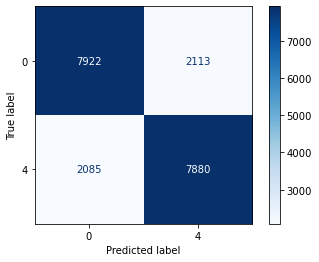

In [207]:
plot_confusion_matrix(pipelineSVC, X_test, y_test, cmap=plt.cm.Blues)

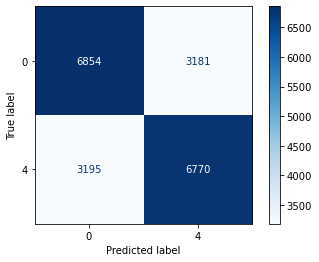

In [208]:
plot_confusion_matrix(pipelineDT, X_test, y_test, cmap=plt.cm.Blues)

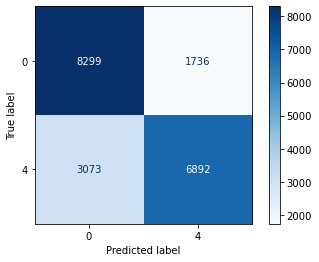

In [209]:
plot_confusion_matrix(pipelineNB, X_test, y_test, cmap=plt.cm.Blues)